## Data set - static system
An static system is excited by an uniform signal $X \sim U[-1, 1]$

In [1]:
from scipy.special import eval_legendre
from models import *

# input signal parameters
x_amp = 1

# sys parameters
sys_dict = Dictionary()

# sys_dict.append(lambda x, t: x[t])
# sys_dict.append(lambda x, t: x[t] ** 2)
# sys_dict.append(lambda x, t: x[t] ** 3)

sys_dict.append(lambda x, t: 10 * eval_legendre(1, x[t]))
sys_dict.append(lambda x, t: 10 * eval_legendre(2, x[t]))
sys_dict.append(lambda x, t: 10 * eval_legendre(3, x[t]))
sys_dict.append(lambda x, t: 10 * eval_legendre(4, x[t]))
sys_dict.append(lambda x, t: 10 * eval_legendre(0, x[t]))

#sys_params = [1/sys_dict.size] * sys_dict.size
#sys_params = np.array([0.8, 0.2, 0.0])
#sys_params = np.array([0.9, 0.1])
sys_params = np.zeros(sys_dict.size)
sys_params[0] = 0.9
sys_params[1] = 0.1

true_sys = DictionaryBasedModel(sys_dict)
true_sys.set_parameters(sys_params)


# noise signal parameters
z_sigma = 1

# generate learning batch
est_batch_size = 1000
x_est = np.random.uniform(-x_amp, x_amp, est_batch_size)
z_est = z_sigma * np.random.standard_normal(est_batch_size)
y_est_no_noise = true_sys.evaluate_output(x_est)
y_est = y_est_no_noise + z_est

# generate validation batch
val_batch_size = 1000
x_val = np.random.uniform(-x_amp, x_amp, val_batch_size)
z_val = z_sigma * np.random.standard_normal(val_batch_size)
y_val_no_noise = true_sys.evaluate_output(x_val)
y_val = y_val_no_noise + z_val

## Entropic descent - example 

To use this method we need following parameters:
- $\sigma_Z^2$ - variance of the noise signal
- $R$ - radius of the $\ell_1$-ball over which we estimate
- $M$ - the system's output magnitude

We also use a _scaling parameter_ that scales the stepsize - apparently the equation for its derivation doesn't work

In [27]:
# derive G numerically
G_sq = 0
x0_range = np.linspace(0, 1, 20)

for x0 in x0_range:
    x1 = 1 - x0
    m = DictionaryBasedModel(sys_dict)
    m.parameters[0] = x0
    m.parameters[1] = x1
    x = np.linspace(-1, 1)
    y_m = m.evaluate_output(x)
    y = true_sys.evaluate_output(x)
    f0 = eval_legendre(1, x)
    f1 = eval_legendre(2, x)
    g0 = (y_m - y) ** 2 * f0 ** 2
    g1 = (y_m - y) ** 2 * f1 ** 2
    g0_int = 0.5 * np.trapz(g0, x)
    g1_int = 0.5 * np.trapz(g1, x)
    G_sq = np.max([G_sq, g0_int, g1_int])
    
G = np.sqrt(G_sq)

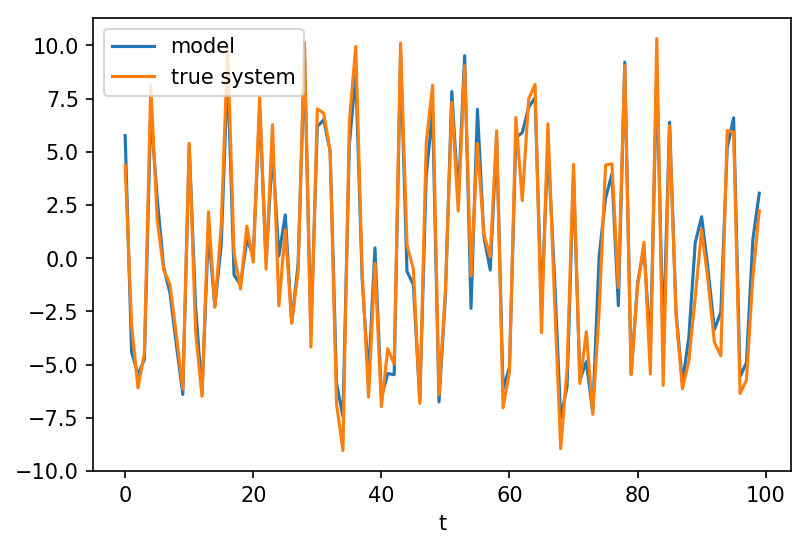

                   G: 200.24984394500785
            stepsize: 0.002831802015523144
Estimated parameters: [0.85931246 0.07894613 0.02307618 0.02892915 0.00973609]
                 MSE: 0.5486022543830322


In [4]:
from entropic_descent import *
import matplotlib.pyplot as plt

z_var = z_sigma ** 2
R = 10
M = 10

# model parameters
m = DictionaryBasedModel(sys_dict)
D = m.dictionary.size

G_sq = R ** 2 * ((R + M) ** 2 + z_var)

scaling_parameter = 1 # this is parameter for scaling the stepsize

stepsize = scaling_parameter * np.sqrt(2 * np.log(D) / (G_sq * (est_batch_size + 1)))
stepsize_function = lambda i: stepsize

alg = EntropicDescentAlgorithm(m.dictionary)
model_parameters = alg.run(x_est, y_est, stepsize_function)
m.set_parameters(model_parameters)
                   
y_ed = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_ed[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()

print("                   G: {0}".format(np.sqrt(G_sq)))
print("            stepsize: {0}".format(stepsize))
print("Estimated parameters: {0}".format(model_parameters))
mse = 0.5 * np.mean(np.square(y_val - y_ed))
print("                 MSE: {0}".format(mse))

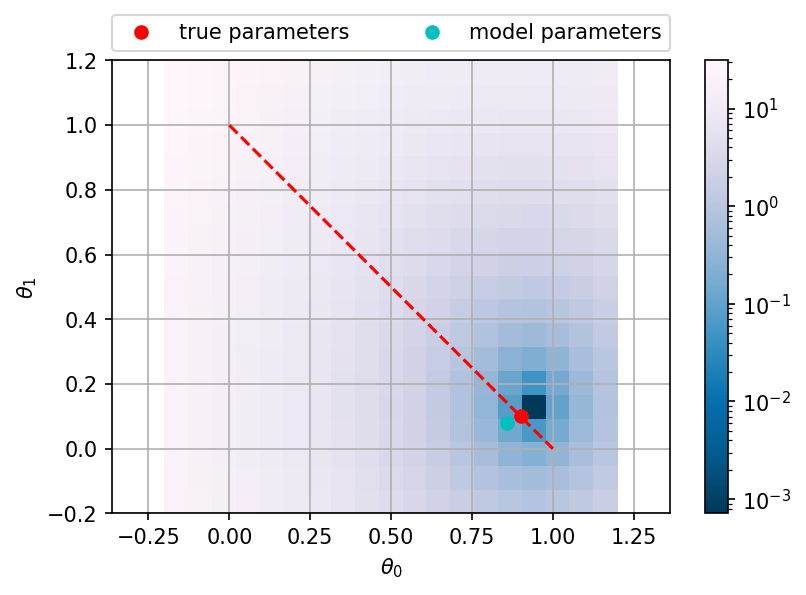

In [5]:
# plot loss function
import matplotlib.pyplot as plt
from matplotlib.colors import *

l1_ball_R = 1
x_constr = np.linspace(0, l1_ball_R)
constr_style = "--r"
plt.rcParams['figure.dpi'] = 150
plt.plot(x_constr, l1_ball_R - x_constr, constr_style, label='_nolegend_')
#plt.plot(x_constr, -l1_ball_R + x_constr, constr_style, label='_nolegend_')
#plt.plot(-x_constr, l1_ball_R - x_constr, constr_style, label='_nolegend_')
#lt.plot(-x_constr, -l1_ball_R + x_constr, constr_style, label='_nolegend_')

x0_idx = 0
x1_idx = 1

x0_range = np.linspace(-0.2 * l1_ball_R, 1.2 * l1_ball_R, 20)
x1_range = x0_range

xx, yy = np.meshgrid(x0_range, x1_range)

L = np.zeros([len(x1_range), len(x0_range)])
for i in range(len(x0_range)):
    for j in range(len(x1_range)):
        x0 = x0_range[i]
        x1 = x1_range[j]
        m = DictionaryBasedModel(sys_dict)
        parameters = sys_params.copy() #np.zeros(m.dictionary.size)
        parameters[x0_idx] = x0
        parameters[x1_idx] = x1
        m.set_parameters(parameters)
        y_m = m.evaluate_output(x_val)

        L[j, i] = 0.5 * np.mean(np.square(y_val_no_noise - y_m))

plt.xlabel(r'$\theta_{0}$'.format(x0_idx))
plt.ylabel(r'$\theta_{0}$'.format(x1_idx))
plt.pcolor(xx, yy, L, norm=LogNorm(vmin=L.min(), vmax=L.max()), cmap='PuBu_r')
plt.colorbar()

plt.plot(sys_params[x0_idx], sys_params[x1_idx], 'ro')
plt.plot(model_parameters[x0_idx], model_parameters[x1_idx], 'co')

plt.legend(['true parameters', 'model parameters'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", 
           mode="expand", borderaxespad=0, ncol=3)

plt.axis('equal')
plt.grid()
plt.show()

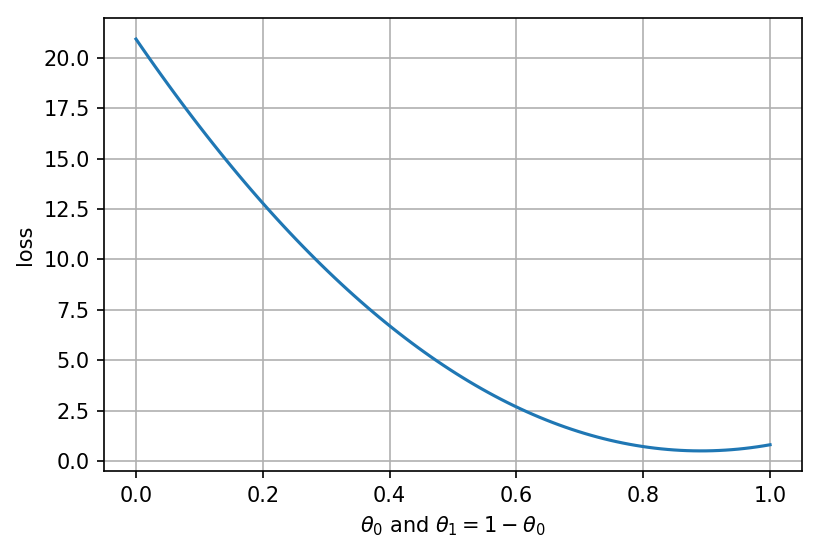

In [6]:
x = np.linspace(0, 1, 100)
y = np.zeros(len(x))
for i in range(len(x)):
        x0 = x[i]
        x1 = 1 - x0
        parameters = sys_params.copy() #np.zeros(m.dictionary.size)
        parameters[x0_idx] = x0
        parameters[x1_idx] = x1
        m = DictionaryBasedModel(sys_dict)
        m.set_parameters(parameters)
        y_m = m.evaluate_output(x_val)

        y[i] = 0.5 * np.mean(np.square(y_val - y_m))
        
plt.plot(x, y)

plt.xlabel(r'$\theta_{0}$ and $\theta_{1}=1-\theta_{0}$'.format(x0_idx, x1_idx))
plt.ylabel('loss')
plt.grid()
plt.show()

In another experiment we check the theoretical properties of the algorithm.
Since $l(\boldsymbol{\theta}^*)=\frac{1}{2}\sigma_Z^2$ we have
 $E\{l(\hat{\boldsymbol{\theta}})\} \leq G\sqrt{\frac{2\ln D}{T}}+\frac{1}{2}\sigma_Z^2$  

           Average loss: 0.5439402864564827
Theoretical upper bound: 11.861202426557448


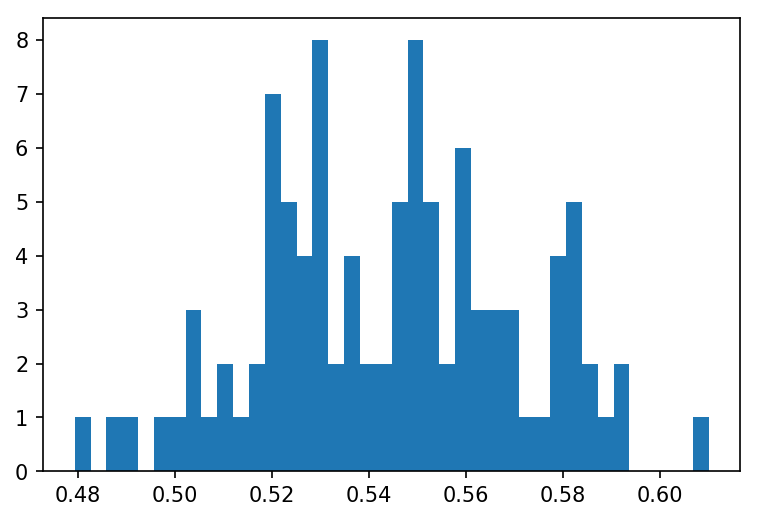

In [8]:
num_of_experiments = 100

avg_mse_in_experiment = np.zeros(num_of_experiments)

for i in range(num_of_experiments):
    # generate learning batch
    x_est = np.random.uniform(-x_amp, x_amp, est_batch_size)
    z_est = z_sigma * np.random.standard_normal(est_batch_size)
    y_est = true_sys.evaluate_output(x_est) + z_est

    # generate validation batch
    x_val = np.random.uniform(-x_amp, x_amp, val_batch_size)
    z_val = z_sigma * np.random.standard_normal(val_batch_size)
    y_val = true_sys.evaluate_output(x_val) + z_val

    m = DictionaryBasedModel(sys_dict)
    alg = EntropicDescentAlgorithm(sys_dict)
    model_parameters = alg.run(x_est, y_est, stepsize_function)
    m.set_parameters(model_parameters)
    
    y_ed = m.evaluate_output(x_val)
    
    avg_mse_in_experiment[i] = 0.5 * np.mean(np.square(y_val - y_ed))
    
    
avg_loss = np.average(avg_mse_in_experiment)
avg_loss_upper_bound = np.sqrt(G_sq * 2 * np.log(D) / est_batch_size) + 0.5 * z_var
print("           Average loss: {0}".format(avg_loss))
print("Theoretical upper bound: {0}".format(avg_loss_upper_bound))

plt.hist(avg_mse_in_experiment, bins=40)
plt.show()